In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
import pandas as pd

In [ ]:
from google.colab import files
files.upload()

In [5]:
gss = spark.read.csv('Global.csv',inferSchema=True, header=True)

In [6]:
gss = gss.drop("Postal Code")

In [7]:
gss = gss.na.drop()

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.sql.types import DateType

In [9]:
gss = gss.withColumn("Sales",col("Sales").cast("double"))

In [10]:
gss = gss.na.drop()

In [11]:
# gss = gss.select("Sales","Profit")
gss = gss.withColumn("Sales",col("Sales").cast("double"))
gss = gss.withColumn("Quantity",col("Quantity").cast("double"))
gss = gss.withColumn("Shipping Cost",col("Shipping Cost").cast("double"))
gss = gss.withColumn("Discount",col("Discount").cast("double"))
gss = gss.withColumn("Profit",col("Profit").cast("double"))

In [12]:
assemble=VectorAssembler(inputCols=['Sales','Shipping Cost', 'Discount','Quantity'],outputCol='features2')

In [13]:
asd_reg = assemble.transform(gss)
asd_reg.show(5)

+------+---------------+----------+----------+------------+-----------+----------------+-----------+-------------+---------------+-------------+------+-------+----------------+----------+------------+--------------------+--------+--------+--------+--------+-------------+--------------+--------------------+
|Row ID|       Order ID|Order Date| Ship Date|   Ship Mode|Customer ID|   Customer Name|    Segment|         City|          State|      Country|Market| Region|      Product ID|  Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|Shipping Cost|Order Priority|           features2|
+------+---------------+----------+----------+------------+-----------+----------------+-----------+-------------+---------------+-------------+------+-------+----------------+----------+------------+--------------------+--------+--------+--------+--------+-------------+--------------+--------------------+
| 32298| CA-2012-124891|31-07-2012|31-07-2012|    Same Day|   RH-19495|     

In [14]:
regdata = asd_reg.select('features2','Profit')

In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data = asd_reg.randomSplit([0.7, 0.3])



In [16]:
train_data = train_data.na.drop()
train_data.show()
train_data = train_data.select('features2','Profit')

+------+--------------+----------+----------+--------------+-----------+----------------+-----------+--------------------+-----------------+------------------+------+---------+---------------+---------------+------------+--------------------+---------+--------+--------+----------+-------------+--------------+--------------------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|    Segment|                City|            State|           Country|Market|   Region|     Product ID|       Category|Sub-Category|        Product Name|    Sales|Quantity|Discount|    Profit|Shipping Cost|Order Priority|           features2|
+------+--------------+----------+----------+--------------+-----------+----------------+-----------+--------------------+-----------------+------------------+------+---------+---------------+---------------+------------+--------------------+---------+--------+--------+----------+-------------+--------------+--------------------+
|   

In [18]:
from pyspark.ml.regression import LinearRegression

In [19]:
models = LinearRegression(featuresCol='features2',labelCol='Profit')
Ecommodel = models.fit(train_data)

summary = Ecommodel.summary

print('RMSE:',summary.rootMeanSquaredError)
print('R2 score:', summary.r2)
print('MAE score:', summary.meanAbsoluteError)
print('MSE score:', summary.meanSquaredError)

RMSE: 146.10920003939833
R2 score: 0.2960265616394514
MAE score: 58.70823377910164
MSE score: 21347.898336152917


In [22]:
Ecommodeltest = models.fit(test_data)

# Get summary of the model
summary = Ecommodeltest.summary

# Print RMSE , R2 , MAE , MSE
print('RMSE:',summary.rootMeanSquaredError)
print('R2 score:', summary.r2)
print('MAE score:', summary.meanAbsoluteError)
print('MSE score:', summary.meanSquaredError)

RMSE: 140.41485856838054
R2 score: 0.36625215092126107
MAE score: 59.053537158428554
MSE score: 19716.33250677831


In [21]:
predictions = Ecommodel.transform(test_data)

# Display the predictions
predictions.show(20)

+------+--------------+----------+----------+--------------+-----------+----------------+-----------+----------------+-------------------+------------------+------+---------+---------------+---------------+------------+--------------------+---------+--------+--------+---------+-------------+--------------+--------------------+-------------------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|    Segment|            City|              State|           Country|Market|   Region|     Product ID|       Category|Sub-Category|        Product Name|    Sales|Quantity|Discount|   Profit|Shipping Cost|Order Priority|           features2|         prediction|
+------+--------------+----------+----------+--------------+-----------+----------------+-----------+----------------+-------------------+------------------+------+---------+---------------+---------------+------------+--------------------+---------+--------+--------+---------+-------------+----------

In [76]:
gss_profit = gss.filter(gss.Profit > 0)
gss_loss = gss.filter(gss.Profit < 0)
gss_profit = gss_profit.select("Profit","Sales")
gss_profit = gss_profit.na.drop()
gss_loss = gss_loss.na.drop()

In [77]:

assemble=VectorAssembler(inputCols=['Profit','Sales'],outputCol='features')    #,'Discount','Quantity','Shipping Cost'], outputCol='features')


In [78]:
asd = assemble.transform(gss_profit)
asd.show(5)


+--------+--------+------------------+
|  Profit|   Sales|          features|
+--------+--------+------------------+
|762.1845| 2309.65|[762.1845,2309.65]|
| 919.971|5175.171|[919.971,5175.171]|
|  311.52| 2832.96|  [311.52,2832.96]|
| 763.275|2862.675|[763.275,2862.675]|
|  564.84| 1822.08|  [564.84,1822.08]|
+--------+--------+------------------+
only showing top 5 rows



In [79]:
gss_profit = gss_profit.toPandas()
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(gss_profit)
    Sum_of_squared_distances.append(km.inertia_)

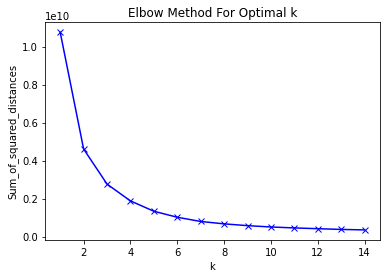

In [80]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [81]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
KMeans_=KMeans(featuresCol='features', k=3) 
KMeans_Model=KMeans_.fit(asd)
KMeans_Assignments=KMeans_Model.transform(asd)

In [82]:
combined_result = KMeans_Assignments.select("Profit", "Sales","prediction")  #"Discount", "Shipping Cost", "Quantity","prediction")
combined_result.show()

+--------+--------+----------+
|  Profit|   Sales|prediction|
+--------+--------+----------+
|762.1845| 2309.65|         1|
| 919.971|5175.171|         1|
|  311.52| 2832.96|         1|
| 763.275|2862.675|         1|
|  564.84| 1822.08|         2|
|  996.48| 5244.84|         1|
|1906.485| 5083.96|         1|
|  83.281| 4164.05|         1|
|  647.55| 4626.15|         1|
|  1151.4| 2616.96|         1|
|  622.02|  2221.8|         1|
| 1036.08| 3701.52|         1|
| 186.948|1869.588|         2|
|517.4793| 2249.91|         1|
| 3979.08| 7958.58|         1|
|  28.404|2565.594|         1|
|  818.28| 3409.74|         1|
|  276.84| 1977.72|         2|
| 341.994|2735.952|         1|
|  358.02|  2754.0|         1|
+--------+--------+----------+
only showing top 20 rows



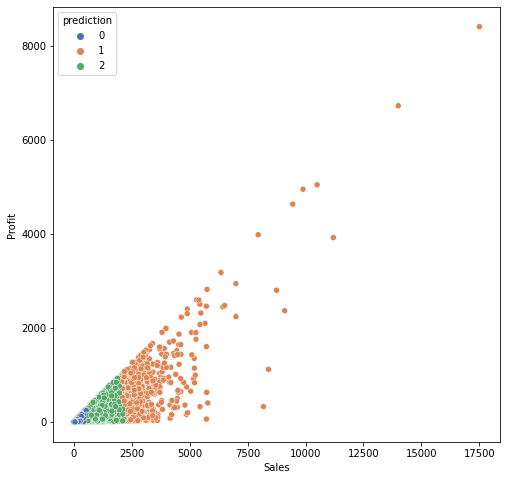

In [83]:
combined_result = combined_result.toPandas()
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Sales', y='Profit', 
                data=combined_result, 
                hue='prediction', 
                palette="deep")

In [84]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,6):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(asd)

    KMeans_transform=KMeans_fit.transform(asd) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

    

In [85]:
print("Silhouette Score:",str(evaluation_score))

Silhouette Score: 0.864654699644835


In [86]:
centers = KMeans_Model.clusterCenters()
print(centers)

[array([ 29.90722947, 125.28437899]), array([ 816.45719293, 3161.62880833]), array([ 233.41979912, 1012.8965264 ])]


Cluster for loss making data

In [87]:
gss_loss = gss.filter(gss.Profit < 0)
gss_loss = gss_loss.filter(gss_loss.Sales < 22000 )

In [89]:
gss_loss = gss_loss.na.drop()

In [91]:
gss_loss = gss_loss.select("Sales","Profit")                                                 #,"Shipping Cost","Discount")
gss_loss = gss_loss.withColumn("Sales",col("Sales").cast("double"))
#gss_loss = gss_loss.withColumn("Quantity",col("Quantity").cast("double"))
#gss_loss = gss_loss.withColumn("Shipping Cost",col("Shipping Cost").cast("double"))
#gss_loss = gss_loss.withColumn("Discount",col("Discount").cast("double"))
gss_loss = gss_loss.withColumn("Profit",col("Profit").cast("double"))

In [92]:
assemble1=VectorAssembler(inputCols=['Profit','Sales'], outputCol='features1')

In [93]:
asdloss = assemble1.transform(gss_loss)
asdloss.show(5)

+--------+----------+--------------------+
|   Sales|    Profit|           features1|
+--------+----------+--------------------+
|3709.395|  -288.765| [-288.765,3709.395]|
| 2892.51|    -96.54|    [-96.54,2892.51]|
|4297.644|-1862.3124|[-1862.3124,4297....|
| 1696.64|   -148.46|   [-148.46,1696.64]|
| 2453.43|   -350.49|   [-350.49,2453.43]|
+--------+----------+--------------------+
only showing top 5 rows



In [94]:
gss_loss = gss_loss.toPandas()
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(gss_loss)
    Sum_of_squared_distances.append(km.inertia_)

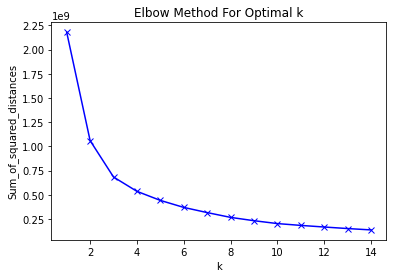

In [95]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [96]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
KMeans_loss=KMeans(featuresCol='features1', k=4) 
KMeans_Model_loss=KMeans_loss.fit(asdloss)
KMeans_Assignments_loss=KMeans_Model_loss.transform(asdloss)

In [97]:
combined_result_loss = KMeans_Assignments_loss.select("Profit", "Sales","prediction")  #, "Discount", "Shipping Cost", "Quantity","prediction")
combined_result_loss.show()

+----------+---------+----------+
|    Profit|    Sales|prediction|
+----------+---------+----------+
|  -288.765| 3709.395|         2|
|    -96.54|  2892.51|         1|
|-1862.3124| 4297.644|         2|
|   -148.46|  1696.64|         1|
|   -350.49|  2453.43|         1|
|-3839.9904|  7999.98|         2|
|  -77.2038|3200.5962|         1|
| -452.8104|3427.1496|         2|
|  -630.882| 4416.174|         2|
| -269.7912|2487.8088|         1|
|    -0.054| 2016.846|         1|
| -2211.165| 2570.865|         2|
|  -1783.08|  2875.77|         2|
|    -37.83|  1695.87|         1|
|  -265.761| 1505.979|         1|
|   -286.92|  1024.68|         3|
|  -214.725| 2760.345|         1|
| -1784.895| 1983.135|         1|
| -317.1528|2396.2656|         1|
| -128.7198|3126.4002|         1|
+----------+---------+----------+
only showing top 20 rows



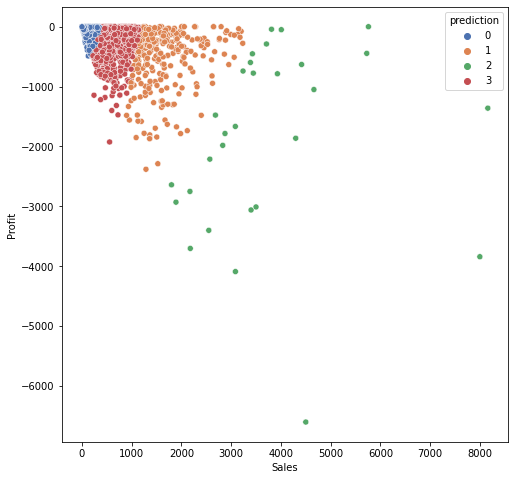

In [98]:
combined_result_loss = combined_result_loss.toPandas()
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Sales', y='Profit', 
                data=combined_result_loss, 
                hue='prediction', 
                palette="deep")

In [99]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features1', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,6):

    KMeans_loss=KMeans(featuresCol='features1', k=K)

    KMeans_fit_loss=KMeans_loss.fit(asdloss)

    KMeans_transform_loss = KMeans_fit_loss.transform(asdloss) 

    evaluation_score_loss = evaluator.evaluate(KMeans_transform_loss)

    silhouette_scores.append(evaluation_score_loss)

In [100]:
print("Silhouette Score:",str(evaluation_score_loss))

Silhouette Score: 0.8263710119504988


In [101]:
centers_loss = KMeans_Model_loss.clusterCenters()
print(centers_loss)

[array([-35.31696073,  77.91218998]), array([-464.39294316, 1645.60204322]), array([-1869.58127241,  3761.95577931]), array([-200.72896617,  588.04453232])]


In [ ]:
from pyspark.ml.feature import StandardScaler

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(asd)

data_scale_output = data_scale.transform(asd)
data_scale_output.show()
data_scale_output.printSchema()

+------+---------------+----------+----------+--------------+-----------+-----------------+-----------+-------------+---------------+-------------+------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+--------+-------------+--------------+------------------+--------------------+
|Row ID|       Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|    Customer Name|    Segment|         City|          State|      Country|Market|      Region|      Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|Shipping Cost|Order Priority|          features|        standardized|
+------+---------------+----------+----------+--------------+-----------+-----------------+-----------+-------------+---------------+-------------+------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+--------+-------------+--------------+------------------+--

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,6):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(data_scale_output)

    KMeans_transform=KMeans_fit.transform(data_scale_output) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

    print("Silhouette Score:",evaluation_score)

Silhouette Score: 0.9292996360965639
Silhouette Score: 0.890289895615105
Silhouette Score: 0.8783428068066612
Silhouette Score: 0.8591295860619125


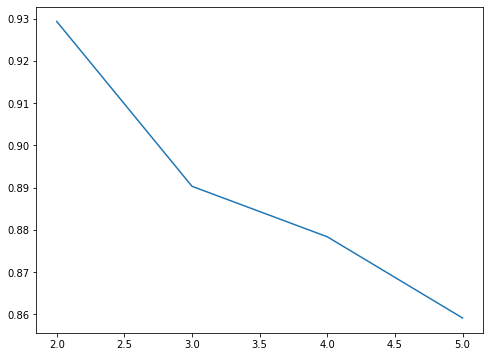

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,6),silhouette_scores)
#ax.set_xlabel(‘Profit’)
#ax.set_ylabel(‘cost’)

In [ ]:
KMeans_=KMeans(featuresCol='features', k=3) 
KMeans_Model=KMeans_.fit(data_scale_output)
KMeans_Assignments=KMeans_Model.transform(data_scale_output)

In [ ]:
KMeans_Assignments.show()

+------+---------------+----------+----------+--------------+-----------+-----------------+-----------+-------------+---------------+-------------+------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+--------+-------------+--------------+------------------+--------------------+----------+
|Row ID|       Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|    Customer Name|    Segment|         City|          State|      Country|Market|      Region|      Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|Shipping Cost|Order Priority|          features|        standardized|prediction|
+------+---------------+----------+----------+--------------+-----------+-----------------+-----------+-------------+---------------+-------------+------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+--------+-------------+--------------

In [ ]:
combined_result = KMeans_Assignments.select("Order ID","Profit", "Sales", "Discount", "Shipping Cost", "Quantity","prediction")
combined_result.show()

+---------------+--------+--------+--------+-------------+--------+----------+
|       Order ID|  Profit|   Sales|Discount|Shipping Cost|Quantity|prediction|
+---------------+--------+--------+--------+-------------+--------+----------+
| CA-2012-124891|762.1845| 2309.65|       0|       933.57|       7|         2|
|  IN-2013-71249| 919.971|5175.171|     0.1|       915.49|       9|         2|
|   SG-2013-4320|  311.52| 2832.96|       0|       903.04|       8|         2|
|  IN-2013-42360| 763.275|2862.675|     0.1|       897.35|       5|         2|
|  IN-2011-81826|  564.84| 1822.08|       0|       894.77|       4|         0|
|  IN-2012-86369|  996.48| 5244.84|       0|       878.38|       6|         2|
| CA-2014-135909|1906.485| 5083.96|     0.2|       867.69|       5|         2|
| CA-2011-102988|  83.281| 4164.05|       0|       846.54|       5|         2|
|  ID-2012-28402|  647.55| 4626.15|       0|       835.57|       5|         2|
|   SA-2011-1830|  1151.4| 2616.96|       0|       8

In [ ]:
combined_result = combined_result.toPandas()


AttributeError: ignored

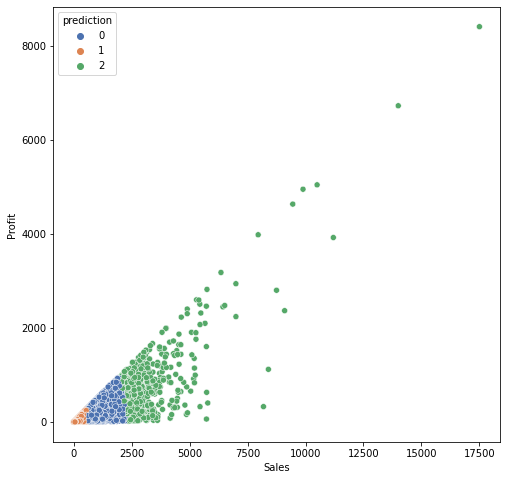

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Sales', y='Profit', 
                data=combined_result, 
                hue='prediction', 
                palette="deep")

In [ ]:
centers = KMeans_Model.clusterCenters()
print(centers)

[array([ 240.86919319, 1040.9904893 ]), array([ 30.26032884, 127.05588139]), array([ 844.15092903, 3263.01650219])]


In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = KMeans_.fit(data_scale_output)
   


In [ ]:
combined_result = combined_result.drop('prediction')

KeyError: ignored

In [ ]:
data_scale_output = data_scale_output.toPandas()
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
  clusterer = KMeans(n_clusters=K)
  clusterer.fit()
  inertia = clusterer.inertia_

Exception ignored in: <function JavaWrapper.__del__ at 0x7f1f960555e0>
Traceback (most recent call last):
  File "/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/ml/wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'KMeans' object has no attribute '_java_obj'


ValueError: ignored